In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-01-02 17:07:36.622605: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 17:07:36.625659: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 17:07:36.668021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 17:07:36.668093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 17:07:36.669476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Download Data

In [2]:
data_folder = "../data/"
seq_length = 5
seq_col_name = "id"

In [3]:
input_url = "/kaggle/input/bank-credit-default-loan-default/data/train_data/train_data_0.pq.zip"
target_url = "/kaggle/input/bank-credit-default-loan-default/target.csv.zip"
input_file_name = "train_data_0.pq"
target_file_name = "target.csv"


download_data(input_url, data_folder, input_file_name)
download_data(target_url, data_folder, target_file_name)

input_df = pd.read_parquet(os.path.join(data_folder, input_file_name))
target_df = pd.read_csv(os.path.join(data_folder, target_file_name))

input_df = input_df.astype("int32")
target_df = target_df.astype("int32")

train_data_0.pq already exists in ../data/
target.csv already exists in ../data/


In [4]:
input_df = input_df.sort_values(by=[seq_col_name, "rn"])
target_df = target_df.sort_values(by=[seq_col_name])

In [5]:
DATASET_LIMIT = 1000
target_df = target_df.iloc[:DATASET_LIMIT]

In [6]:
max_id = np.max(target_df[seq_col_name].values)

In [7]:
input_df = input_df[input_df[seq_col_name] <= max_id]

## Preprocess

In [8]:
# Column information
NUMERIC_FEATURES = [
    'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
    'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
    'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
    'pre_loans_outstanding', 'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
    'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
    'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
    'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
    'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
    'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
    'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
    'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
    'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
    'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
    'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
    'enc_loans_account_holder_type',
    'pclose_flag',
    'fclose_flag'
]
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = [
    'enc_loans_credit_status', 'enc_loans_account_cur',
    'enc_loans_credit_type',
]
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'flag'

In [9]:
train_labels, test_labels = train_test_split(target_df, test_size=0.2)

train_input = input_df[input_df[seq_col_name].isin(train_labels[seq_col_name])]
test_input = input_df[input_df[seq_col_name].isin(test_labels[seq_col_name])]

## Get Lookup Tables for Each Categorical Column

In [10]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = tf.keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-01-02 17:07:44.996838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 17:07:44.998808: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
feature_unique_counts

{'enc_loans_account_cur': 4,
 'enc_loans_credit_status': 7,
 'enc_loans_credit_type': 7}

## Convert Each Categorical String to an ID

In [12]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat].to_numpy().astype(str))
    test_input[cat] = cat_lookups[cat](test_input[cat].to_numpy().astype(str))

/tmp/ipykernel_775203/2487444970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat].to_numpy().astype(str))
/tmp/ipykernel_775203/2487444970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat].to_numpy().astype(str))


In [13]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [14]:
y_train, y_val = train_test_split(train_labels, test_size=0.2)

x_train = train_input[train_input[seq_col_name].isin(y_train[seq_col_name])]
x_val = train_input[train_input[seq_col_name].isin(y_val[seq_col_name])]

## Modelling Prep

In [15]:
# Make sure the target and input are in the same order
x_train = x_train.sort_values(by=[seq_col_name, "rn"])
x_val = x_val.sort_values(by=[seq_col_name, "rn"])
test_input = test_input.sort_values(by=[seq_col_name, "rn"])

y_train = y_train.sort_values(by=[seq_col_name])
y_val = y_val.sort_values(by=[seq_col_name])
test_labels = test_labels.sort_values(by=[seq_col_name])

In [16]:
batch_size = 100
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    seq_col_name=seq_col_name,
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    seq_col_name=seq_col_name,
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    seq_col_name=seq_col_name,
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Sequential FT-Transformer

In [17]:
EXPLANATIONS = True
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
N_BINS = 10
NUM_EPOCHS = 3

# Pass the encoder to the model
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    feature_unique_counts = feature_unique_counts,
    seq_length=seq_length,
    numerical_embedding_type='linear',
    n_bins=N_BINS,
    explainable=EXPLANATIONS
)


optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": tf.keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})
model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [18]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/3


7/7 [==============================] - 20s 2s/step - loss: 0.4619 - output_loss: 0.4619 - output_PR AUC: 0.0260 - val_loss: 0.1926 - val_output_loss: 0.1926 - val_output_PR AUC: 0.0320
Epoch 2/3
7/7 [==============================] - 11s 2s/step - loss: 0.1494 - output_loss: 0.1494 - output_PR AUC: 0.0386 - val_loss: 0.2198 - val_output_loss: 0.2198 - val_output_PR AUC: 0.0287
Epoch 3/3
7/7 [==============================] - 12s 2s/step - loss: 0.1557 - output_loss: 0.1557 - output_PR AUC: 0.0267 - val_loss: 0.1871 - val_output_loss: 0.1871 - val_output_PR AUC: 0.0525


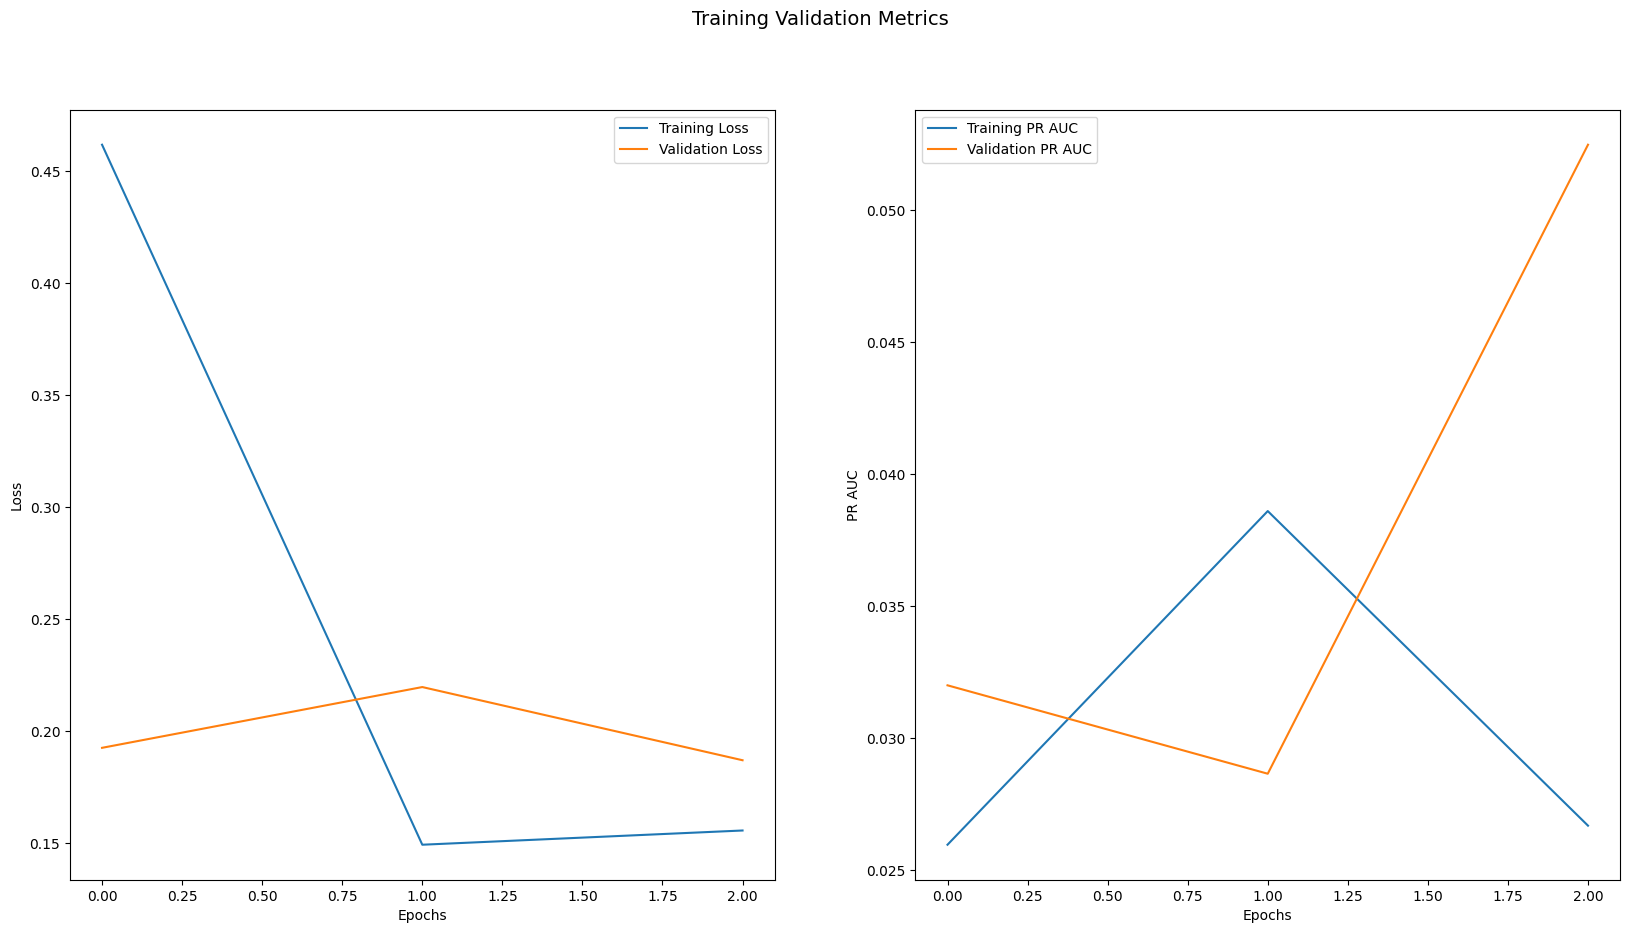

In [19]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [20]:
preds = model.predict(test_dataset)
print("Test ROC AUC:", np.round(roc_auc_score(test_labels[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_labels[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_labels[LABEL], preds['output'].ravel()>0.5), 4))

2/2 [==============================] - 10s 3s/step
Test ROC AUC: 0.8401
Test PR AUC: 0.2524
Test Accuracy: 0.965


## Explainability

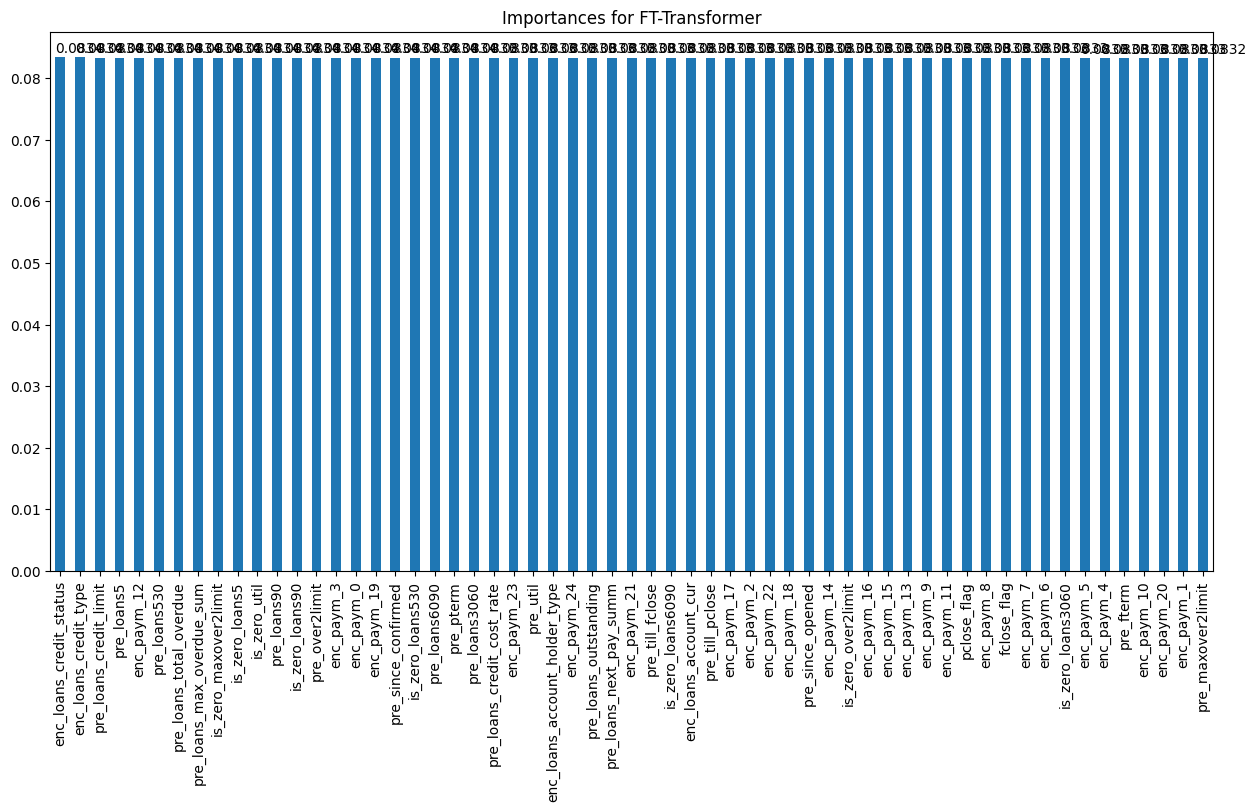

In [21]:
if 'importances' in preds.keys():
    importances = preds['importances']
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )